In [4]:
import cv2
import matplotlib.colors
import requests
import tempfile
import matplotlib.pyplot as plt
import numpy as np

In [27]:
src = cv2.imread("1.jpg")
assert src is not None and len(src), "Empty"

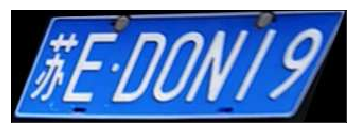

In [28]:
plt.imshow(cv2.cvtColor(src, cv2.COLOR_BGR2RGB))
_ = plt.xticks([]), plt.yticks([])
plt.show()

In [29]:
bw = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)

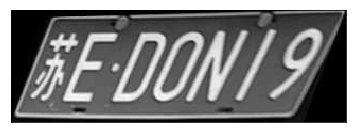

In [30]:
plt.imshow(bw, cmap = 'gray', )
_ = plt.xticks([]), plt.yticks([])
plt.show()

In [31]:
bw_blur = cv2.blur(bw, (3,3))

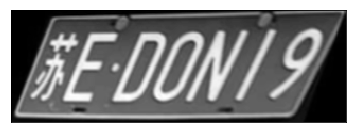

In [32]:
plt.imshow(bw_blur, cmap = 'gray', )
_ = plt.xticks([]), plt.yticks([])
plt.show()

In [33]:
threshold_min = 100
ratio_min_max = 1
bw_canny = cv2.Canny(bw_blur, threshold_min, threshold_min*ratio_min_max, apertureSize=3)

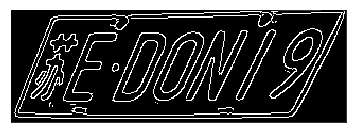

In [34]:
plt.imshow(bw_canny, cmap = 'gray', )
_ = plt.xticks([]), plt.yticks([])
plt.show()

In [41]:
lines = cv2.HoughLinesP(bw_canny, 1, np.pi/180, 70, minLineLength=80, maxLineGap=10)[0]

In [42]:
len(lines)

5

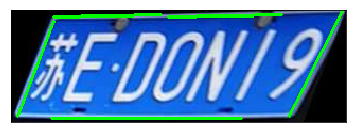

In [43]:
src_lines = src.copy()    
for x1,y1,x2,y2 in lines:
    cv2.line(src_lines,(x1,y1),(x2,y2),(0,255,0),2)
    
plt.imshow(cv2.cvtColor(src_lines, cv2.COLOR_BGR2RGB))
_ = plt.xticks([]), plt.yticks([])
plt.show()

In [45]:
def computeIntersect(a, b):
    x1 = a[0]
    y1 = a[1]
    x2 = a[2]
    y2 = a[3]
    x3 = b[0]
    y3 = b[1]
    x4 = b[2]
    y4 = b[3]
    d = ((x1 - x2) * (y3 - y4)) - ((y1 - y2) * (x3 - x4))
    
    if d:
        d = float(d)
        x = ((x1 * y2 - y1 * x2) * (x3 - x4) - (x1 - x2) * (x3 * y4 - y3 * x4)) / d
        y = ((x1 * y2 - y1 * x2) * (y3 - y4) - (y1 - y2) * (x3 * y4 - y3 * x4)) / d
        return int(x), int(y)
    else:
        return -1, -1

In [103]:
corners = []
for i, lineI in enumerate(lines):
    for lineJ in lines[i+1:]:
        x, y = computeIntersect(lineI, lineJ)
        if x >=0 and y >= 0:
            corners.append((x, y))

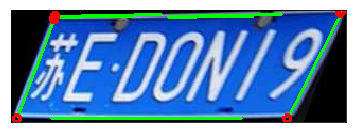

In [104]:
src_corners = src.copy()    
for x1,y1,x2,y2 in lines:
    cv2.line(src_corners,(x1,y1),(x2,y2),(0,255,0),2)

for x1,y1 in corners:
    cv2.circle(src_corners,(x1,y1),3,(0,0,255),2)
    
plt.imshow(cv2.cvtColor(src_corners, cv2.COLOR_BGR2RGB))
_ = plt.xticks([]), plt.yticks([])
plt.show()

In [105]:
corners_mat = np.array(corners)

In [106]:
corners = cv2.approxPolyDP(corners_mat, cv2.arcLength(corners_mat, True) * 0.02, True)
corners = np.array([x[0] for x in corners])
print corners

[[312   1]
 [ 41   6]
 [260 102]
 [  5 102]
 [310   3]
 [ 40   9]]


In [107]:
def build_distances(corners):
    dists = np.array([]).reshape(0,3)
    leng = len(corners)
    for index_a in range(leng):
        index_b = index_a + 1
        while index_b < leng:
            dist = np.linalg.norm(corners[index_a] - corners[index_b])
            print ("dist: ", dist)
            dists = np.vstack([dists, [index_a, index_b, dist]])
            index_b += 1
    return dists
    
length = len(corners)
while length > 4:                
    dists = build_distances(corners)
    print dists, "\n"

    dists = dists[dists[:,2].argsort()]
    print dists, "\n"

    corner_a = int(dists[0][0])
    corner_b = int(dists[0][1])
    new_corner = (corners[corner_a] + corners[corner_b])/2
    corners = np.delete(corners, [corner_a, corner_b], 0)
    corners = np.vstack([corners, new_corner])
    length = len(corners)
    print corners, "\n"


('dist: ', 271.04612153653852)
('dist: ', 113.6001760562016)
('dist: ', 323.18725222384626)
('dist: ', 2.8284271247461903)
('dist: ', 272.11762162711921)
('dist: ', 239.11712611187014)
('dist: ', 102.52804494381037)
('dist: ', 269.01672810440618)
('dist: ', 3.1622776601683795)
('dist: ', 255.0)
('dist: ', 110.90987332063814)
('dist: ', 238.8493248891443)
('dist: ', 320.66493416025395)
('dist: ', 99.368002898317329)
('dist: ', 270.06665843824555)
[[   0.            1.          271.04612154]
 [   0.            2.          113.60017606]
 [   0.            3.          323.18725222]
 [   0.            4.            2.82842712]
 [   0.            5.          272.11762163]
 [   1.            2.          239.11712611]
 [   1.            3.          102.52804494]
 [   1.            4.          269.0167281 ]
 [   1.            5.            3.16227766]
 [   2.            3.          255.        ]
 [   2.            4.          110.90987332]
 [   2.            5.          238.84932489]
 [   3.   

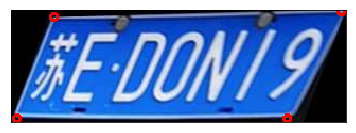

In [108]:
src_poly = src.copy()    

for vert in corners:
    vert = vert
    x1,y1 = vert
    cv2.circle(src_poly,(x1,y1),3,(0,0,255),2)
    
plt.imshow(cv2.cvtColor(src_poly, cv2.COLOR_BGR2RGB))
_ = plt.xticks([]), plt.yticks([])
plt.show()

In [109]:
assert len(corners) == 4, "The object is not quadrilateral!"

In [110]:
def sortCorners(corners, center):
    top = []
    bot = []
    for corner in corners:
        if (corner[1] < center[1]):
            top.append(corner)
        else:
            bot.append(corner)


    tl = top[1] if top[0][0] > top[1][0] else top[0];
    tr = top[0] if top[0][0] > top[1][0] else top[1];
    bl = bot[1] if bot[0][0] > bot[1][0] else bot[0];
    br = bot[0] if bot[0][0] > bot[1][0] else bot[1];

    return np.array((tl, tr, br, bl),np.float32)

In [111]:
center = np.mean(corners, axis=0)
corners_order = sortCorners(corners, center)

In [116]:
size = (450, 140)

In [117]:
transmtx = cv2.getPerspectiveTransform(corners_order, np.array([[0,0], [size[0],0], size, [0, size[1]]],np.float32))

In [118]:
quad = cv2.warpPerspective(src, transmtx, size)

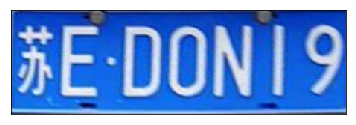

In [119]:
plt.imshow(cv2.cvtColor(quad, cv2.COLOR_BGR2RGB))
_ = plt.xticks([]), plt.yticks([])
plt.show()